In [3]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from itertools import cycle
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [20]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    "training/MultiClassification/train",
    classes = ["humidity", "none", "scale"],
    target_size=(200,200),
    batch_size=120,
    class_mode="categorical",
    shuffle=False)

valid_generator = validation_datagen.flow_from_directory(
    "training/MultiClassification/valid",
    classes = ["humidity", "none", "scale"],
    target_size=(200,200),
    batch_size=120,
    class_mode="categorical",
    shuffle=False)

Found 10652 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [21]:
wandb.login()

def make_model():
    inputs = tf.keras.layers.Flatten(input_shape=(200,200,3))
    x1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)(inputs)
    x2 = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x1)
    x3 = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x2)
    outputs = tf.keras.layers.Dense(3, activation=tf.nn.sigmoid)(x3)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):

    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

In [ ]:
def train(train_dataset, val_dataset,  model, optimizer, train_acc_metric, val_acc_metric, epochs=10,  log_step=200, val_log_step=50):
  
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train, model, optimizer, loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # ⭐: log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc), 
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

In [22]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [23]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = valid_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 3s 310ms/step - loss: 37.2176 - accuracy: 0.5073 - val_loss: 71.9982 - val_accuracy: 0.3333
Epoch 2/15
8/8 [==============================] - 2s 239ms/step - loss: 27.8459 - accuracy: 0.7500
Epoch 3/15
8/8 [==============================] - 2s 236ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 4/15
8/8 [==============================] - 2s 235ms/step - loss: 4.5701 - accuracy: 0.7281
Epoch 5/15
8/8 [==============================] - 2s 241ms/step - loss: 1.8971 - accuracy: 0.8750
Epoch 6/15
8/8 [==============================] - 2s 235ms/step - loss: 1.6332 - accuracy: 0.7573
Epoch 7/15
8/8 [==============================] - 2s 235ms/step - loss: 8.7270 - accuracy: 0.6250
Epoch 8/15
8/8 [==============================] - 2s 237ms/step - loss: 0.4775 - accuracy: 1.0000
Epoch 9/15
8/8 [==============================] - 2s 239ms/step - loss: 1.6248 - accuracy: 0.8750
Epoch 10/15
8/8 [==============================] - 2s 231ms/step - loss: 

In [24]:
test_loss, test_acc = model.evaluate(valid_generator)

4/4 [==============================] - 0s 51ms/step - loss: 0.6816 - accuracy: 0.4056


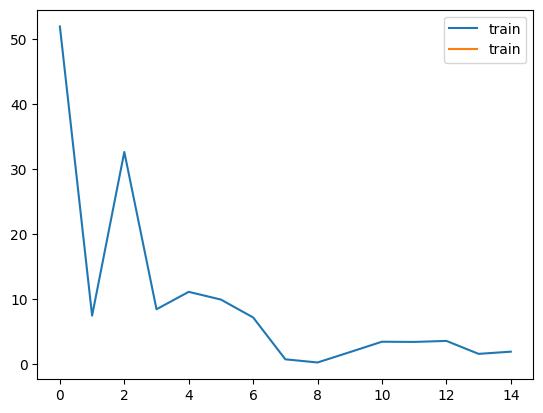

In [14]:

a = history.history
plt.plot(a["loss"], label="train")
plt.plot(a["val_accuracy"], label="train")
plt.legend()
plt.show()